<a href="https://colab.research.google.com/github/mukulsn/Machine-Learning/blob/main/Tensorflow%20Developer%20Certificate/cv/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Date - 17 Dec 2023
Daniel Bourke Udemy course - Tensorflow Dev Certificate <br>
https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/
<br>
Useful topics <br>
1. Functional API in transfer learning
2. Data Augmentation within the model layer
3. Keras guide on finetuning -- https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fkeras.io%2Fguides%2Ftransfer_learning%2F
4. ULMFiT paper for text classification -- https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Farxiv.org%2Fabs%2F1801.06146

In [ ]:
# Transfer Learning
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-19 19:00:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.207, 142.250.97.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   121MB/s    in 1.3s    

2023-12-19 19:00:34 (121 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Creating data loaders (preparing the data)
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing Images:')
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


using ResNetV2 and EfficientNet <br>
3 types of transfer learning <br>
> "As is" transfer learning <br>
> Feature Extraction <br>
> Fine-tuning <br>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, optimizers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
# create model from tensorflow hub link

def create_model(model_url, num_classes=10):
  """Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, deafault 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extraction layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save it as a Keras Layer
  feaure_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False, # freeze the underlying patterns
                                          name='feature_extraction_layer',
                                          input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feaure_extractor_layer, # use the feature extraction layer as the base
      layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [ ]:
# Resnet v2 50 model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 30s 680ms/step - loss: 1.9108 - accuracy: 0.3893 - val_loss: 1.1654 - val_accuracy: 0.6412
Epoch 2/5
24/24 [==============================] - 13s 575ms/step - loss: 0.8856 - accuracy: 0.7373 - val_loss: 0.8205 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 12s 497ms/step - loss: 0.6104 - accuracy: 0.8240 - val_loss: 0.7190 - val_accuracy: 0.7672
Epoch 4/5
24/24 [==============================] - 12s 494ms/step - loss: 0.4684 - accuracy: 0.8827 - val_loss: 0.6858 - val_accuracy: 0.7840
Epoch 5/5
24/24 [==============================] - 12s 511ms/step - loss: 0.3762 - accuracy: 0.9213 - val_loss: 0.6719 - val_accuracy: 0.7844


In [ ]:
# check our model training curves
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs=range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='training_accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.legend();

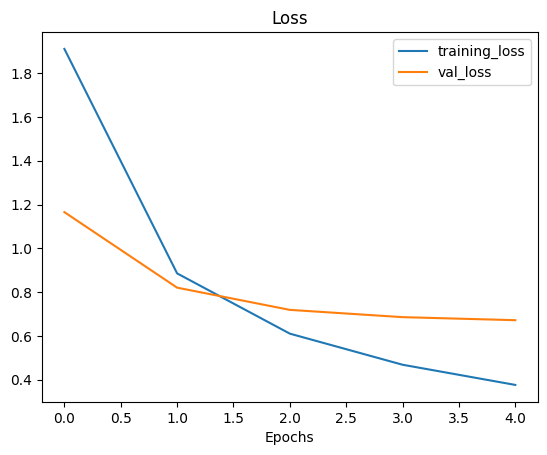

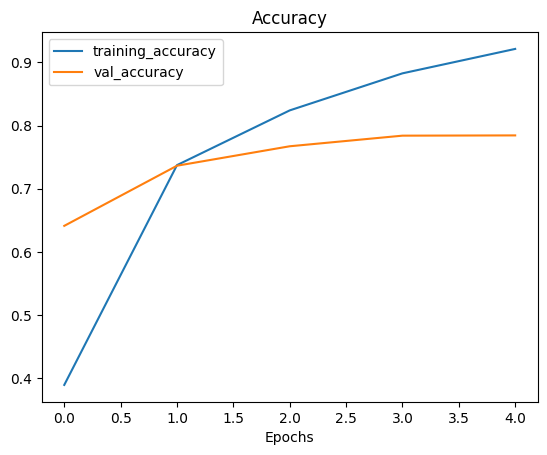

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Create Model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 Tensorflow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet mdoel
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit Efficientnet Model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 28s 652ms/step - loss: 1.8453 - accuracy: 0.4267 - val_loss: 1.2831 - val_accuracy: 0.7432
Epoch 2/5
24/24 [==============================] - 12s 496ms/step - loss: 1.0463 - accuracy: 0.7800 - val_loss: 0.8577 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 11s 491ms/step - loss: 0.7435 - accuracy: 0.8387 - val_loss: 0.6903 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 11s 486ms/step - loss: 0.5984 - accuracy: 0.8707 - val_loss: 0.6054 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 13s 554ms/step - loss: 0.5064 - accuracy: 0.8960 - val_loss: 0.5525 - val_accuracy: 0.8620


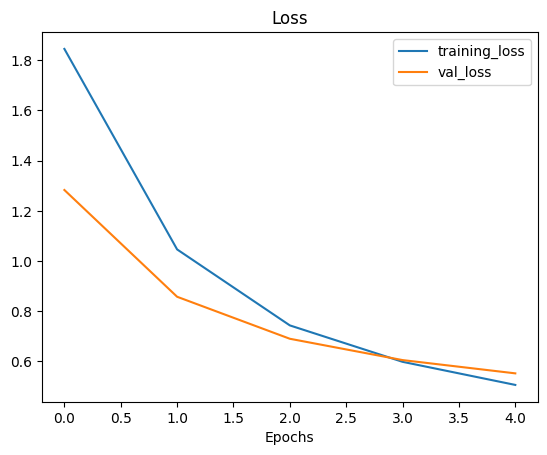

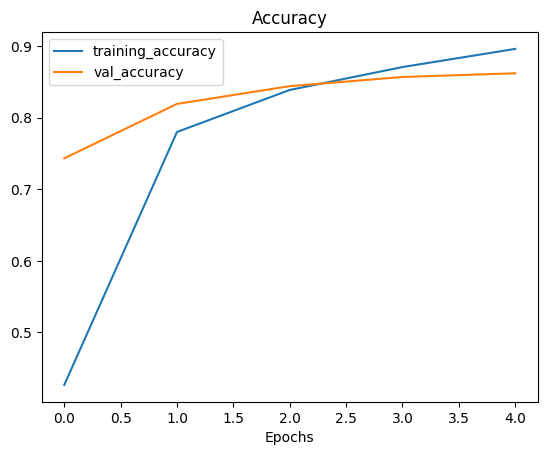

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
# use mobilenet_v2 architecture for the same dataset
mobilenet_model = create_model(model_url="https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/100-224-feature-vector/versions/1",
                               num_clases=train_data_10_percent.num_classes)

# Compile model
mobilenet_model.compile(loss='categorical_cressentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fit the model
mobilenet_model.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=len(test_data))

In [ ]:
plot_loss_curves(mobilenet_model)

In [ ]:
mobilenet_model.summary()

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-12-19 19:02:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-19 19:02:30 (48.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-12-19 19:02:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   134MB/s    in 1.0s    

2023-12-19 19:02:37 (134 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
# data
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# transfer leaning 5th chapter Daniel Bourke
tensorflow developer certification <br>

Running a series of modelling experiments on our Food Vision data
1. Model 0: a transfer learning model using the Keras
Functional API
2. Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
3. Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
4. Model 3: a fine-tuned transfer learning model on 10% of the data
5. Model 4: a fine-tuned transfer learning model on 100% of the data

<br>
### This notebook shows what are the benefits of functional API vs Sequential API
`https://www.tensorflow.org/guide/keras/functional_api`

In [ ]:
# MODEL 0
# create base model with tf.keras.application
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable=False # freeze the base model (so the pre-learned patterns remain)

# create inputs into the base modl
inputs=tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# Efficientnet inputs dont have to be normalized
x = base_model(inputs)
print(f'Shape after base_model: {x.shape}')

# average pool the outputs of the base model (aggregate all the most important information. reduce number of computation)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'After GlobalAveragePooling2D():',{x.shape})

# create output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# combine the input with the outputs into a model
model_0=tf.keras.Model(inputs,outputs)

# compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)))

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): {TensorShape([None, 1280])}
Epoch 1/5
24/24 [==============================] - 20s 365ms/step - loss: 1.9022 - accuracy: 0.3947 - val_loss: 2.4301 - val_accuracy: 0.0905
Epoch 2/5
24/24 [==============================] - 4s 166ms/step - loss: 1.1530 - accuracy: 0.7373 - val_loss: 2.4990 - val_accuracy: 0.0938
Epoch 3/5
24/24 [==============================] - 4s 133ms/step - loss: 0.8474 - accuracy: 0.8160 - val_loss: 2.5545 - val_accuracy: 0.1053
Epoch 4/5
24/24 [==============================] - 3s 129ms/step - loss: 0.6817 - accuracy: 0.8387 - val_loss: 2.5111 - val_accuracy: 0.1234
Epoch 5/5
24/24 [==============================] - 4s 170ms/step - loss: 0.5943 - accuracy: 0.8573 - val_loss: 2.5333 - val_accuracy: 0.1086


In [ ]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

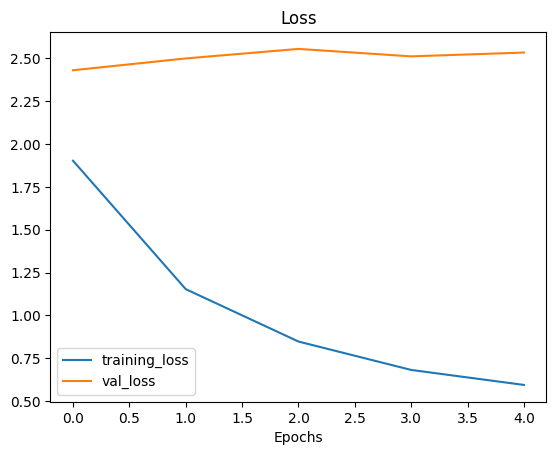

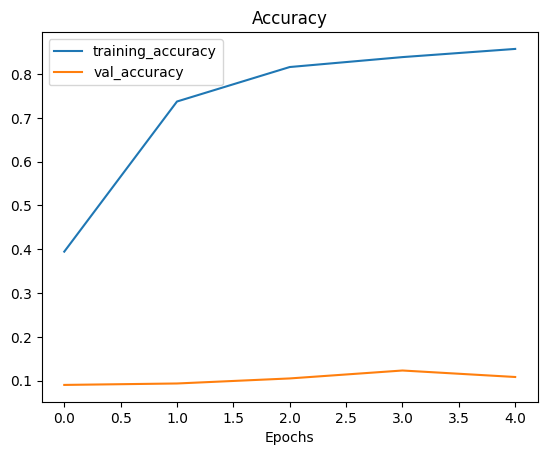

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

In [ ]:
# understanding use case of GlobalAveragePool2D
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor} \n')

# Check the sahpes of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of 2D global average pooled input tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global average pooled input tensor: (1, 3)


In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1,2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-12-19 19:09:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.207, 173.194.213.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   160MB/s    in 0.8s    

2023-12-19 19:09:38 (160 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Image augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # rescaling required for resnet50v2
], name='data_augmentation')

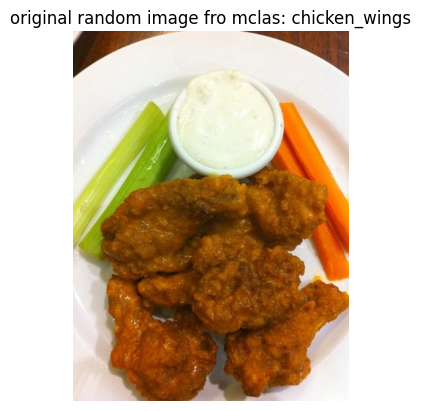

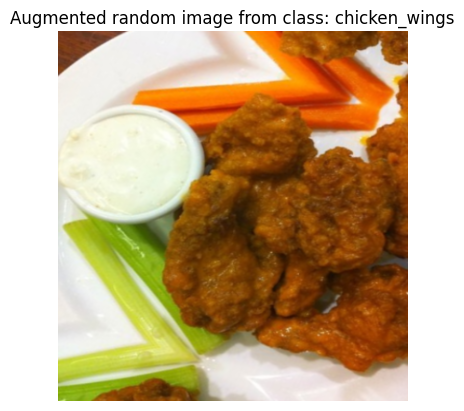

In [ ]:
# view a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = '10_food_classes_1_percent/train/' + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image path
random_image_path = target_dir + '/' + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f'original random image fro mclas: {target_class}')
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, wihdth, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False);

In [ ]:
# Model 1: Feature extraction transfer learning on 1% of the data with data augmentation
#setup input shape and base model, freezing the base model layers
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)
# Give base_model inputs(after augmentation) and don't tran it
x = base_model(x, training=False)
# Pool output features of base model
x=layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
# Put a dense layer on as the output
outputs=layers.Dense(10,activation='softmax',name='output_layer')(x)
# Make a model with inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# # Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data))) # validate for less steps

Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.5186 - accuracy: 0.0571 - val_loss: 2.3904 - val_accuracy: 0.1102
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.3004 - accuracy: 0.1429 - val_loss: 2.2773 - val_accuracy: 0.1447
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 2.1764 - accuracy: 0.2143 - val_loss: 2.1621 - val_accuracy: 0.1842
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.9867 - accuracy: 0.3571 - val_loss: 2.0512 - val_accuracy: 0.2812
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.7847 - accuracy: 0.5429 - val_loss: 1.9777 - val_accuracy: 0.3306


In [ ]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 68ms/step - loss: 1.9640 - accuracy: 0.3464


[1.9639883041381836, 0.3463999927043915]

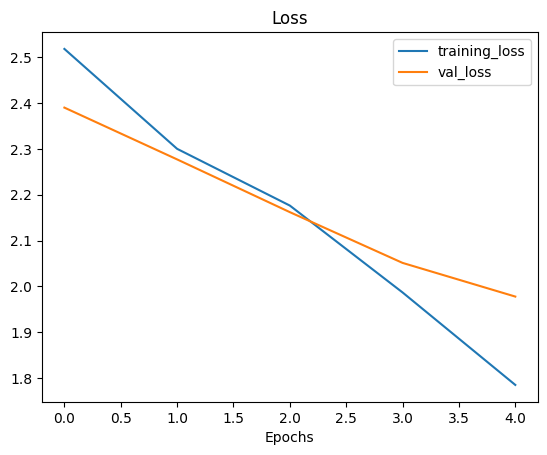

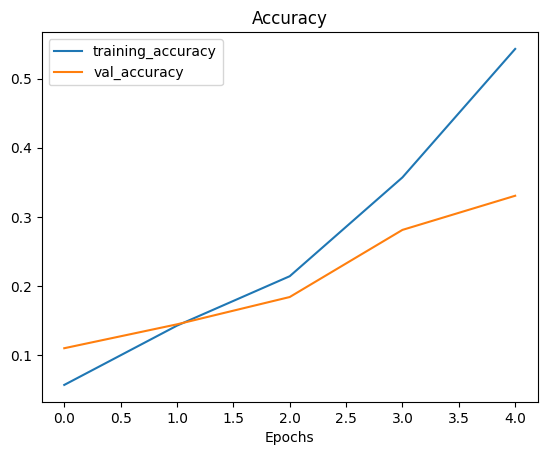

In [ ]:
plot_loss_curves(history_1_percent)

In [ ]:
# Model 2: Feature Extraction transfer learning with 10% of data and data augmentation
# using 10% of data
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
],name='data_augmentation')

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name='input_layer') # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode,
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs,outputs)

# compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy']) # use Adam optimizer with base learning rate

In [ ]:
# when we want to experiment multiple experiments with model_2, create a function for reusability

def create_base_model(input_shape: tuple[int,int,int] = (224,224,3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
   """
   Create a model based on EfficientNetV2B0 with built-in data augmentation.

   Parameters:
   - input_shape (tuple): Expected shape of input images. Default is (224,224,3).
   - output_Shape (int): Number of classes for the output layer. Deafault is 10.
   - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
   - training (bool): Whether the base model is trainable. Default is False.

   Returns:
   - tf.keras.Model: The compiled model with specified input and output settings
   """

   # Create base model
   base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
   base_model.trainable=training

   # Setup model input and outputs with data augmentation built-in
   inputs=layers.Input(shape=input_shape,name='input_layer')
   x=data_augmentation(inputs)
   x=base_model(x, training=False) # pass augmented images to base model but keep it in tinference mode
   x=layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
   outputs=layers.Dense(units=output_shape, activation='softmax',name='output_layer')(x)
   model=tf.keras.Model(inputs,outputs)

   # compile model
   model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['accuracy'])

   return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
# Setup checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weight/checkpoint.ckpt' # note: remember saving directly to colab is temporary

# Create a ModelCheckpoint callback that saves the mdoel's weights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True, # set to False to save the entire model
                                                       save_best_only=True, # save only the best model weights instead of a model every epoch
                                                       save_freq='epoch', # save every epoch
                                                       verbose=1)

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs=5
history_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                        epochs=initial_epochs,
                                        validation_data=test_data,
                                        validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                        callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0458 - accuracy: 0.3160
Epoch 1: val_loss improved from inf to 1.51554, saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 38s 1s/step - loss: 2.0458 - accuracy: 0.3160 - val_loss: 1.5155 - val_accuracy: 0.6480
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4171 - accuracy: 0.6533
Epoch 2: val_loss improved from 1.51554 to 1.08008, saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 27s 1s/step - loss: 1.4171 - accuracy: 0.6533 - val_loss: 1.0801 - val_accuracy: 0.7599
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1335 - accuracy: 0.7040
Epoch 3: val_loss improved from 1.08008 to 0.87986, saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 23s 940ms/step - loss: 1.1335 - accuracy: 0.7040 - val_loss: 0.

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 58ms/step - loss: 0.6477 - accuracy: 0.8384


[0.647732675075531, 0.8384000062942505]

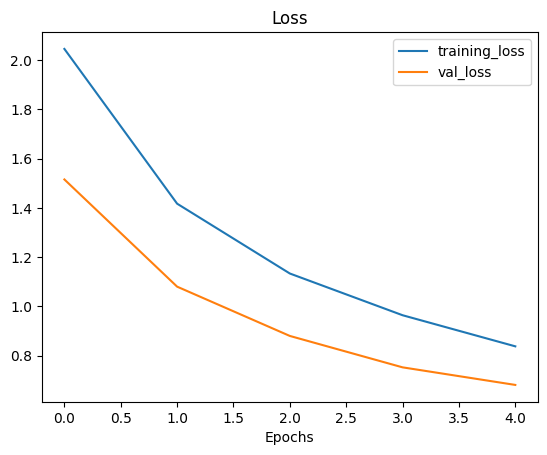

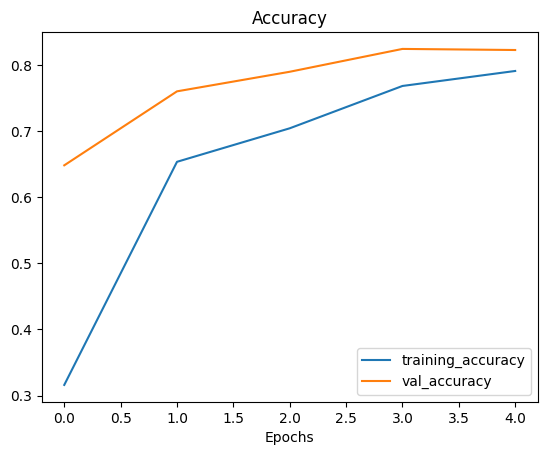

In [ ]:
# plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 56ms/step - loss: 0.6477 - accuracy: 0.8384


In [ ]:
# check if the restuls are same
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the differences between the two results (small values)
import numpy as np
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# layers name and if they are trainable?
for layer_number, layer in enumerate(model_2.layers):
  print(f'Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}')

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x794f91a16770> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x79509054c430> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x794f90c525f0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x794f91df1300> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x794f90c37fa0> | Trainable? True


In [ ]:
model_2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [ ]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


In [ ]:
# Check which laye are tunable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable=False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=['accuracy'])



In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 False
1 rescaling_7 False
2 normalization_7 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# checking trainable layers
print(len(model_2.trainable_variables))

12


Wonderful, it looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model(same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25*len(test_data)))

Epoch 5/10
24/24 [==============================] - 33s 967ms/step - loss: 0.7109 - accuracy: 0.8067 - val_loss: 0.5266 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - 19s 769ms/step - loss: 0.6074 - accuracy: 0.8227 - val_loss: 0.5099 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 17s 696ms/step - loss: 0.5603 - accuracy: 0.8147 - val_loss: 0.4747 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 16s 636ms/step - loss: 0.5014 - accuracy: 0.8387 - val_loss: 0.4909 - val_accuracy: 0.8388
Epoch 9/10
24/24 [==============================] - 18s 741ms/step - loss: 0.4924 - accuracy: 0.8427 - val_loss: 0.4513 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 17s 664ms/step - loss: 0.4675 - accuracy: 0.8480 - val_loss: 0.4545 - val_accuracy: 0.8470


In [ ]:
# Evaluate the mdoel on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 56ms/step - loss: 0.4387 - accuracy: 0.8548


In [ ]:
# Comparing model_2 with feature extraction and fine tuning with unfreezing layers
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  print(len(acc))

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history with new history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss+new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  print(len(total_acc))
  print(total_acc)

  # Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Sart Fine Tuning') # Reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Trainig and validation loss')
  plt.xlabel('epoch')
  plt.show()



#### fine tuning usually works best with larger amount of data

5
11
[0.3160000145435333, 0.653333306312561, 0.7039999961853027, 0.7680000066757202, 0.7906666398048401, 0.8066666722297668, 0.8226666450500488, 0.8146666884422302, 0.8386666774749756, 0.8426666855812073, 0.8479999899864197]


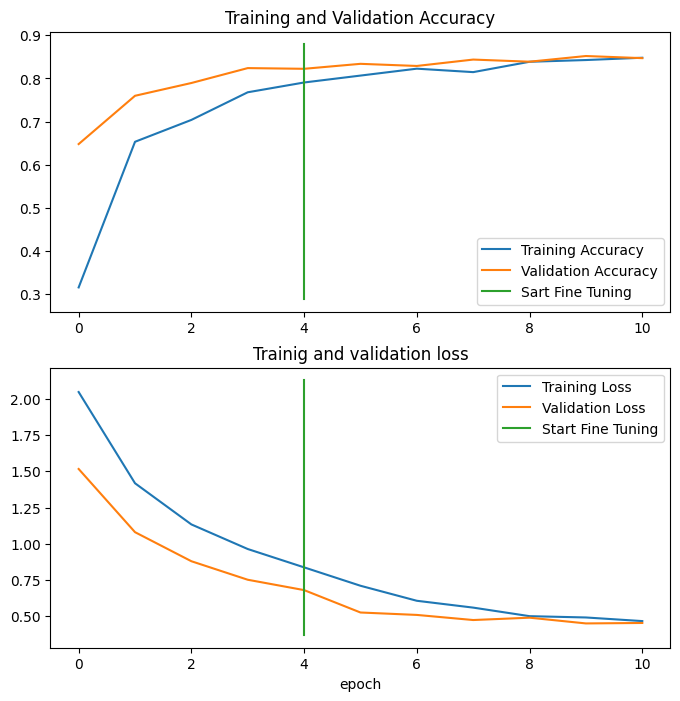

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

#### Model 4: Fine-tuning an existing mdoel all of the data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-12-19 19:28:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.207, 108.177.11.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  83.6MB/s    in 8.6s    

2023-12-19 19:29:03 (57.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model (this is the fine tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.4387 - accuracy: 0.8548


[0.43870341777801514, 0.8547999858856201]

In [ ]:
results_fine_tune_10_percent

[0.4387035071849823, 0.8547999858856201]

In [ ]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine tuning

In [ ]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
print(len(model_2.trainable_variables))

2


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 73ms/step - loss: 0.6477 - accuracy: 0.8384


[0.6477327942848206, 0.8384000062942505]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# continue to train and fine-tune the model to our data
fine_tune_epochs= initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)))

Epoch 5/10
235/235 [==============================] - 132s 518ms/step - loss: 0.6526 - accuracy: 0.7911 - val_loss: 0.3099 - val_accuracy: 0.9013
Epoch 6/10
235/235 [==============================] - 97s 409ms/step - loss: 0.4655 - accuracy: 0.8504 - val_loss: 0.2661 - val_accuracy: 0.9112
Epoch 7/10
235/235 [==============================] - 84s 355ms/step - loss: 0.3915 - accuracy: 0.8756 - val_loss: 0.2901 - val_accuracy: 0.9211
Epoch 8/10
235/235 [==============================] - 73s 312ms/step - loss: 0.3367 - accuracy: 0.8924 - val_loss: 0.2735 - val_accuracy: 0.9178
Epoch 9/10
235/235 [==============================] - 67s 281ms/step - loss: 0.2937 - accuracy: 0.9040 - val_loss: 0.2933 - val_accuracy: 0.9211
Epoch 10/10
235/235 [==============================] - 61s 261ms/step - loss: 0.2512 - accuracy: 0.9179 - val_loss: 0.3411 - val_accuracy: 0.8914


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 56ms/step - loss: 0.2680 - accuracy: 0.9124


[0.2679935395717621, 0.9124000072479248]

In [ ]:
results_fine_tune_10_percent

[0.4387035071849823, 0.8547999858856201]

5
11
[0.3160000145435333, 0.653333306312561, 0.7039999961853027, 0.7680000066757202, 0.7906666398048401, 0.7910666465759277, 0.8503999710083008, 0.8755999803543091, 0.8924000263214111, 0.9039999842643738, 0.9178666472434998]


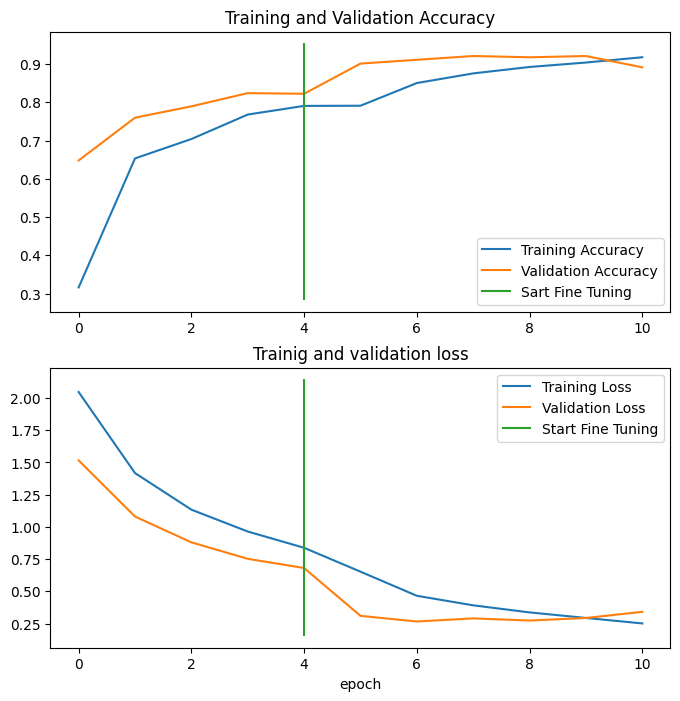

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [ ]:
tf.save_model.save(model_2,'/content/')

AttributeError: ignored

In [ ]:
!pwd

/content


In [ ]:
model_2.save('/content/finalmodel_ch5')

In [ ]:
!cp -a /content/finalmodel_ch5 "/content/drive/MyDrive/Colab Notebooks/ML projects/Tensorflow projects/Tensorflow Developer Certificate/CV/"